<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[21:09:00] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


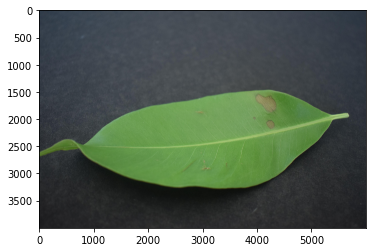

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

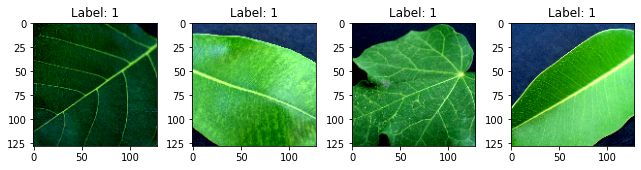

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[21:09:05] /work/mxnet/src/storage/storage.cc:199: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[21:09:07] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.254487875022703 samples/sec                   batch loss = 0.7338464856147766 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.247659024094375 samples/sec                   batch loss = 0.6583957076072693 | accuracy = 0.425


Epoch[1] Batch[15] Speed: 1.2324155871936209 samples/sec                   batch loss = 1.049635410308838 | accuracy = 0.45


Epoch[1] Batch[20] Speed: 1.2633475273925714 samples/sec                   batch loss = 1.0198228359222412 | accuracy = 0.475


Epoch[1] Batch[25] Speed: 1.2645605751916564 samples/sec                   batch loss = 0.4081678092479706 | accuracy = 0.51


Epoch[1] Batch[30] Speed: 1.2603565462723765 samples/sec                   batch loss = 1.1861308813095093 | accuracy = 0.5083333333333333


Epoch[1] Batch[35] Speed: 1.2733311186749512 samples/sec                   batch loss = 0.3786662220954895 | accuracy = 0.5285714285714286


Epoch[1] Batch[40] Speed: 1.2665737691774708 samples/sec                   batch loss = 0.3589783310890198 | accuracy = 0.54375


Epoch[1] Batch[45] Speed: 1.2662174043971752 samples/sec                   batch loss = 0.6772441864013672 | accuracy = 0.5444444444444444


Epoch[1] Batch[50] Speed: 1.2697691512659535 samples/sec                   batch loss = 0.4916272759437561 | accuracy = 0.545


Epoch[1] Batch[55] Speed: 1.2671307037896364 samples/sec                   batch loss = 0.8775190114974976 | accuracy = 0.5409090909090909


Epoch[1] Batch[60] Speed: 1.2703445787075363 samples/sec                   batch loss = 0.4431611895561218 | accuracy = 0.5458333333333333


Epoch[1] Batch[65] Speed: 1.2626548721052522 samples/sec                   batch loss = 0.6124008893966675 | accuracy = 0.5576923076923077


Epoch[1] Batch[70] Speed: 1.2656031271468564 samples/sec                   batch loss = 0.8591935634613037 | accuracy = 0.5535714285714286


Epoch[1] Batch[75] Speed: 1.2621257905769308 samples/sec                   batch loss = 0.6812527775764465 | accuracy = 0.56


Epoch[1] Batch[80] Speed: 1.274262842322238 samples/sec                   batch loss = 0.1734217405319214 | accuracy = 0.571875


Epoch[1] Batch[85] Speed: 1.2695489250932646 samples/sec                   batch loss = 0.49357590079307556 | accuracy = 0.5794117647058824


Epoch[1] Batch[90] Speed: 1.2607436300277206 samples/sec                   batch loss = 1.0233546495437622 | accuracy = 0.5666666666666667


Epoch[1] Batch[95] Speed: 1.2679685579286089 samples/sec                   batch loss = 0.35266226530075073 | accuracy = 0.5684210526315789


Epoch[1] Batch[100] Speed: 1.269521065969298 samples/sec                   batch loss = 0.4790385067462921 | accuracy = 0.5675


Epoch[1] Batch[105] Speed: 1.270639176216534 samples/sec                   batch loss = 0.6418353319168091 | accuracy = 0.5619047619047619


Epoch[1] Batch[110] Speed: 1.2676501980295423 samples/sec                   batch loss = 0.6124628782272339 | accuracy = 0.5545454545454546


Epoch[1] Batch[115] Speed: 1.2624874558056067 samples/sec                   batch loss = 0.850997269153595 | accuracy = 0.5608695652173913


Epoch[1] Batch[120] Speed: 1.2758085942172555 samples/sec                   batch loss = 0.6969732642173767 | accuracy = 0.5625


Epoch[1] Batch[125] Speed: 1.277991730067124 samples/sec                   batch loss = 0.5561398267745972 | accuracy = 0.564


Epoch[1] Batch[130] Speed: 1.27811216343048 samples/sec                   batch loss = 0.5534753203392029 | accuracy = 0.5615384615384615


Epoch[1] Batch[135] Speed: 1.272021816898695 samples/sec                   batch loss = 0.6623480319976807 | accuracy = 0.5648148148148148


Epoch[1] Batch[140] Speed: 1.2741800984091523 samples/sec                   batch loss = 0.550444483757019 | accuracy = 0.5696428571428571


Epoch[1] Batch[145] Speed: 1.2746472827349626 samples/sec                   batch loss = 0.5505861639976501 | accuracy = 0.5689655172413793


Epoch[1] Batch[150] Speed: 1.281128141861982 samples/sec                   batch loss = 0.666641116142273 | accuracy = 0.5716666666666667


Epoch[1] Batch[155] Speed: 1.2761939680320455 samples/sec                   batch loss = 0.35277509689331055 | accuracy = 0.5741935483870968


Epoch[1] Batch[160] Speed: 1.2721454684201934 samples/sec                   batch loss = 0.6706811189651489 | accuracy = 0.56875


Epoch[1] Batch[165] Speed: 1.2702358949944779 samples/sec                   batch loss = 1.0909581184387207 | accuracy = 0.5681818181818182


Epoch[1] Batch[170] Speed: 1.2711255320501422 samples/sec                   batch loss = 0.5986785888671875 | accuracy = 0.5764705882352941


Epoch[1] Batch[175] Speed: 1.267260776733159 samples/sec                   batch loss = 0.6647775173187256 | accuracy = 0.5757142857142857


Epoch[1] Batch[180] Speed: 1.2691169580194497 samples/sec                   batch loss = 0.19998691976070404 | accuracy = 0.5833333333333334


Epoch[1] Batch[185] Speed: 1.2627979047323565 samples/sec                   batch loss = 0.6221254467964172 | accuracy = 0.5851351351351352


Epoch[1] Batch[190] Speed: 1.2653933148842866 samples/sec                   batch loss = 0.6374800801277161 | accuracy = 0.5881578947368421


Epoch[1] Batch[195] Speed: 1.2641018971908171 samples/sec                   batch loss = 0.9949164390563965 | accuracy = 0.5923076923076923


Epoch[1] Batch[200] Speed: 1.2677287432426325 samples/sec                   batch loss = 0.262357622385025 | accuracy = 0.59375


Epoch[1] Batch[205] Speed: 1.264816642019507 samples/sec                   batch loss = 0.528640627861023 | accuracy = 0.5914634146341463


Epoch[1] Batch[210] Speed: 1.2578114392717759 samples/sec                   batch loss = 0.314339816570282 | accuracy = 0.5904761904761905


Epoch[1] Batch[215] Speed: 1.2633252669405732 samples/sec                   batch loss = 0.710818350315094 | accuracy = 0.5953488372093023


Epoch[1] Batch[220] Speed: 1.2634453304672413 samples/sec                   batch loss = 0.4346550405025482 | accuracy = 0.5977272727272728


Epoch[1] Batch[225] Speed: 1.264716147737931 samples/sec                   batch loss = 1.106680154800415 | accuracy = 0.5988888888888889


Epoch[1] Batch[230] Speed: 1.2555015696748004 samples/sec                   batch loss = 0.4933055639266968 | accuracy = 0.6043478260869565


Epoch[1] Batch[235] Speed: 1.2607770741571156 samples/sec                   batch loss = 0.28422167897224426 | accuracy = 0.6053191489361702


Epoch[1] Batch[240] Speed: 1.2684865336656845 samples/sec                   batch loss = 0.6602633595466614 | accuracy = 0.6072916666666667


Epoch[1] Batch[245] Speed: 1.264504532697087 samples/sec                   batch loss = 0.5418422818183899 | accuracy = 0.610204081632653


Epoch[1] Batch[250] Speed: 1.2632246290468954 samples/sec                   batch loss = 0.4605409801006317 | accuracy = 0.613


Epoch[1] Batch[255] Speed: 1.255588483010895 samples/sec                   batch loss = 0.5363578796386719 | accuracy = 0.6147058823529412


Epoch[1] Batch[260] Speed: 1.2656396939087886 samples/sec                   batch loss = 0.6002254486083984 | accuracy = 0.6182692307692308


Epoch[1] Batch[265] Speed: 1.2644048503323269 samples/sec                   batch loss = 0.5308743715286255 | accuracy = 0.6179245283018868


Epoch[1] Batch[270] Speed: 1.2617563614955754 samples/sec                   batch loss = 0.7466249465942383 | accuracy = 0.6194444444444445


Epoch[1] Batch[275] Speed: 1.2672226804938216 samples/sec                   batch loss = 0.5252504348754883 | accuracy = 0.6218181818181818


Epoch[1] Batch[280] Speed: 1.2650743388437293 samples/sec                   batch loss = 0.5468870997428894 | accuracy = 0.6214285714285714


Epoch[1] Batch[285] Speed: 1.2706972074408258 samples/sec                   batch loss = 0.4238503575325012 | accuracy = 0.624561403508772


Epoch[1] Batch[290] Speed: 1.2660057643759455 samples/sec                   batch loss = 0.7580478191375732 | accuracy = 0.6267241379310344


Epoch[1] Batch[295] Speed: 1.2642384939350941 samples/sec                   batch loss = 0.9975645542144775 | accuracy = 0.6288135593220339


Epoch[1] Batch[300] Speed: 1.265519976658672 samples/sec                   batch loss = 0.4472219944000244 | accuracy = 0.6325


Epoch[1] Batch[305] Speed: 1.2634447595882414 samples/sec                   batch loss = 0.3161872625350952 | accuracy = 0.6327868852459017


Epoch[1] Batch[310] Speed: 1.2627847880988299 samples/sec                   batch loss = 0.7904282212257385 | accuracy = 0.6346774193548387


Epoch[1] Batch[315] Speed: 1.2642071521841822 samples/sec                   batch loss = 0.6982320547103882 | accuracy = 0.6365079365079365


Epoch[1] Batch[320] Speed: 1.2658578017168725 samples/sec                   batch loss = 1.085763692855835 | accuracy = 0.63515625


Epoch[1] Batch[325] Speed: 1.2639225754367942 samples/sec                   batch loss = 0.3152291476726532 | accuracy = 0.6353846153846154


Epoch[1] Batch[330] Speed: 1.2683336757948926 samples/sec                   batch loss = 1.8691470623016357 | accuracy = 0.6378787878787879


Epoch[1] Batch[335] Speed: 1.2711816813993138 samples/sec                   batch loss = 0.5206637978553772 | accuracy = 0.6395522388059701


Epoch[1] Batch[340] Speed: 1.2699527314494443 samples/sec                   batch loss = 0.3339954614639282 | accuracy = 0.6389705882352941


Epoch[1] Batch[345] Speed: 1.275371000320568 samples/sec                   batch loss = 0.7244687676429749 | accuracy = 0.6398550724637682


Epoch[1] Batch[350] Speed: 1.2732752624478947 samples/sec                   batch loss = 0.7278584241867065 | accuracy = 0.6421428571428571


Epoch[1] Batch[355] Speed: 1.2743492752170096 samples/sec                   batch loss = 0.6063889861106873 | accuracy = 0.6443661971830986


Epoch[1] Batch[360] Speed: 1.2775194648452521 samples/sec                   batch loss = 0.7344545125961304 | accuracy = 0.6444444444444445


Epoch[1] Batch[365] Speed: 1.266719603896436 samples/sec                   batch loss = 0.599357008934021 | accuracy = 0.6431506849315068


Epoch[1] Batch[370] Speed: 1.2646902163220355 samples/sec                   batch loss = 0.36263471841812134 | accuracy = 0.6459459459459459


Epoch[1] Batch[375] Speed: 1.2609076464116866 samples/sec                   batch loss = 0.549487829208374 | accuracy = 0.6453333333333333


Epoch[1] Batch[380] Speed: 1.2663872453190055 samples/sec                   batch loss = 0.5762266516685486 | accuracy = 0.6460526315789473


Epoch[1] Batch[385] Speed: 1.2681477835364534 samples/sec                   batch loss = 0.524000883102417 | accuracy = 0.6467532467532467


Epoch[1] Batch[390] Speed: 1.2714821598806276 samples/sec                   batch loss = 0.6401309967041016 | accuracy = 0.6474358974358975


Epoch[1] Batch[395] Speed: 1.2679239989975843 samples/sec                   batch loss = 0.4678477644920349 | accuracy = 0.6487341772151899


Epoch[1] Batch[400] Speed: 1.2665840004197482 samples/sec                   batch loss = 0.5271409153938293 | accuracy = 0.64875


Epoch[1] Batch[405] Speed: 1.267262499732796 samples/sec                   batch loss = 0.24875278770923615 | accuracy = 0.6518518518518519


Epoch[1] Batch[410] Speed: 1.2652962596824802 samples/sec                   batch loss = 0.6361236572265625 | accuracy = 0.6530487804878049


Epoch[1] Batch[415] Speed: 1.2657683149458403 samples/sec                   batch loss = 0.7824946045875549 | accuracy = 0.6542168674698795


Epoch[1] Batch[420] Speed: 1.2605661121484415 samples/sec                   batch loss = 0.5338022708892822 | accuracy = 0.6553571428571429


Epoch[1] Batch[425] Speed: 1.2639707578023782 samples/sec                   batch loss = 0.46527960896492004 | accuracy = 0.6552941176470588


Epoch[1] Batch[430] Speed: 1.2657627761591819 samples/sec                   batch loss = 0.8813864588737488 | accuracy = 0.6546511627906977


Epoch[1] Batch[435] Speed: 1.2678987982360435 samples/sec                   batch loss = 1.1489239931106567 | accuracy = 0.6557471264367816


Epoch[1] Batch[440] Speed: 1.2629905034906252 samples/sec                   batch loss = 0.385385662317276 | accuracy = 0.6579545454545455


Epoch[1] Batch[445] Speed: 1.2639629493435154 samples/sec                   batch loss = 1.251889944076538 | accuracy = 0.6589887640449438


Epoch[1] Batch[450] Speed: 1.2635715073829148 samples/sec                   batch loss = 0.6349157691001892 | accuracy = 0.6583333333333333


Epoch[1] Batch[455] Speed: 1.2653283234709838 samples/sec                   batch loss = 0.40547847747802734 | accuracy = 0.6582417582417582


Epoch[1] Batch[460] Speed: 1.2674608674512278 samples/sec                   batch loss = 0.6312254667282104 | accuracy = 0.658695652173913


Epoch[1] Batch[465] Speed: 1.2672975350749556 samples/sec                   batch loss = 0.7005744576454163 | accuracy = 0.6586021505376344


Epoch[1] Batch[470] Speed: 1.2672083232089648 samples/sec                   batch loss = 0.6620981693267822 | accuracy = 0.6590425531914894


Epoch[1] Batch[475] Speed: 1.2653009355504259 samples/sec                   batch loss = 0.9569100737571716 | accuracy = 0.6584210526315789


Epoch[1] Batch[480] Speed: 1.2787830916212621 samples/sec                   batch loss = 0.30048567056655884 | accuracy = 0.6588541666666666


Epoch[1] Batch[485] Speed: 1.2750843800564382 samples/sec                   batch loss = 0.31352007389068604 | accuracy = 0.6603092783505154


Epoch[1] Batch[490] Speed: 1.2702252199868203 samples/sec                   batch loss = 0.7451191544532776 | accuracy = 0.661734693877551


Epoch[1] Batch[495] Speed: 1.2783613777536287 samples/sec                   batch loss = 0.647229015827179 | accuracy = 0.6636363636363637


Epoch[1] Batch[500] Speed: 1.2641861950414428 samples/sec                   batch loss = 0.5746116042137146 | accuracy = 0.663


Epoch[1] Batch[505] Speed: 1.2779043156993135 samples/sec                   batch loss = 0.656261682510376 | accuracy = 0.6628712871287129


Epoch[1] Batch[510] Speed: 1.2739328984588245 samples/sec                   batch loss = 0.7956784963607788 | accuracy = 0.6622549019607843


Epoch[1] Batch[515] Speed: 1.2722436737271225 samples/sec                   batch loss = 0.2668542265892029 | accuracy = 0.6611650485436893


Epoch[1] Batch[520] Speed: 1.2761591185708236 samples/sec                   batch loss = 0.7492089867591858 | accuracy = 0.6625


Epoch[1] Batch[525] Speed: 1.2723446924487387 samples/sec                   batch loss = 0.6245704889297485 | accuracy = 0.6638095238095238


Epoch[1] Batch[530] Speed: 1.2742909099498758 samples/sec                   batch loss = 0.5233067274093628 | accuracy = 0.6641509433962264


Epoch[1] Batch[535] Speed: 1.2665979610730544 samples/sec                   batch loss = 0.579149067401886 | accuracy = 0.6644859813084112


Epoch[1] Batch[540] Speed: 1.2653328087138125 samples/sec                   batch loss = 0.36135217547416687 | accuracy = 0.663425925925926


Epoch[1] Batch[545] Speed: 1.2753195213124684 samples/sec                   batch loss = 0.7175567746162415 | accuracy = 0.6619266055045872


Epoch[1] Batch[550] Speed: 1.2731953521113506 samples/sec                   batch loss = 0.45328181982040405 | accuracy = 0.6640909090909091


Epoch[1] Batch[555] Speed: 1.2692901705080288 samples/sec                   batch loss = 0.6094700694084167 | accuracy = 0.6648648648648648


Epoch[1] Batch[560] Speed: 1.267672228021807 samples/sec                   batch loss = 0.24086157977581024 | accuracy = 0.6651785714285714


Epoch[1] Batch[565] Speed: 1.268396962539489 samples/sec                   batch loss = 0.8368501663208008 | accuracy = 0.6641592920353983


Epoch[1] Batch[570] Speed: 1.2718596210123938 samples/sec                   batch loss = 0.42378565669059753 | accuracy = 0.6644736842105263


Epoch[1] Batch[575] Speed: 1.2722718454347246 samples/sec                   batch loss = 0.7234160304069519 | accuracy = 0.6643478260869565


Epoch[1] Batch[580] Speed: 1.2720409128339822 samples/sec                   batch loss = 0.6810862421989441 | accuracy = 0.6646551724137931


Epoch[1] Batch[585] Speed: 1.262645844554847 samples/sec                   batch loss = 0.9865362644195557 | accuracy = 0.6653846153846154


Epoch[1] Batch[590] Speed: 1.2731843374464973 samples/sec                   batch loss = 0.5493451356887817 | accuracy = 0.6661016949152543


Epoch[1] Batch[595] Speed: 1.2672702532891422 samples/sec                   batch loss = 1.0659921169281006 | accuracy = 0.6663865546218487


Epoch[1] Batch[600] Speed: 1.2674033229305415 samples/sec                   batch loss = 0.5343920588493347 | accuracy = 0.6666666666666666


Epoch[1] Batch[605] Speed: 1.2671909991850263 samples/sec                   batch loss = 0.42253246903419495 | accuracy = 0.6677685950413224


Epoch[1] Batch[610] Speed: 1.2698390208173866 samples/sec                   batch loss = 0.36521250009536743 | accuracy = 0.6684426229508197


Epoch[1] Batch[615] Speed: 1.2741783565475306 samples/sec                   batch loss = 0.3836958706378937 | accuracy = 0.6699186991869919


Epoch[1] Batch[620] Speed: 1.2666020728309841 samples/sec                   batch loss = 0.5807569026947021 | accuracy = 0.6705645161290322


Epoch[1] Batch[625] Speed: 1.2699638825317079 samples/sec                   batch loss = 0.671593964099884 | accuracy = 0.6712


Epoch[1] Batch[630] Speed: 1.267994528126488 samples/sec                   batch loss = 0.5712279677391052 | accuracy = 0.671031746031746


Epoch[1] Batch[635] Speed: 1.2740329279013871 samples/sec                   batch loss = 0.46350526809692383 | accuracy = 0.6716535433070866


Epoch[1] Batch[640] Speed: 1.2719416780892538 samples/sec                   batch loss = 0.4917929470539093 | accuracy = 0.671875


Epoch[1] Batch[645] Speed: 1.2684936308482309 samples/sec                   batch loss = 0.5009729266166687 | accuracy = 0.672093023255814


Epoch[1] Batch[650] Speed: 1.271174939362925 samples/sec                   batch loss = 0.47921133041381836 | accuracy = 0.671923076923077


Epoch[1] Batch[655] Speed: 1.2632267215430728 samples/sec                   batch loss = 0.4448642134666443 | accuracy = 0.6725190839694657


Epoch[1] Batch[660] Speed: 1.271473294743753 samples/sec                   batch loss = 0.26764950156211853 | accuracy = 0.671969696969697


Epoch[1] Batch[665] Speed: 1.2754474024411613 samples/sec                   batch loss = 0.3720855712890625 | accuracy = 0.6725563909774436


Epoch[1] Batch[670] Speed: 1.2694252975491713 samples/sec                   batch loss = 0.49418678879737854 | accuracy = 0.6727611940298508


Epoch[1] Batch[675] Speed: 1.2738169265365518 samples/sec                   batch loss = 0.5843505263328552 | accuracy = 0.6714814814814815


Epoch[1] Batch[680] Speed: 1.267063811327512 samples/sec                   batch loss = 0.5004690885543823 | accuracy = 0.6720588235294118


Epoch[1] Batch[685] Speed: 1.270523610745718 samples/sec                   batch loss = 1.0465915203094482 | accuracy = 0.672992700729927


Epoch[1] Batch[690] Speed: 1.2645280737521585 samples/sec                   batch loss = 1.9748588800430298 | accuracy = 0.672463768115942


Epoch[1] Batch[695] Speed: 1.2691500798116202 samples/sec                   batch loss = 0.5505127906799316 | accuracy = 0.673021582733813


Epoch[1] Batch[700] Speed: 1.2632108377682303 samples/sec                   batch loss = 0.6664292812347412 | accuracy = 0.6728571428571428


Epoch[1] Batch[705] Speed: 1.2702101214084773 samples/sec                   batch loss = 0.5392574667930603 | accuracy = 0.6741134751773049


Epoch[1] Batch[710] Speed: 1.2666255007983405 samples/sec                   batch loss = 0.9737071394920349 | accuracy = 0.6742957746478874


Epoch[1] Batch[715] Speed: 1.265698319706587 samples/sec                   batch loss = 0.9414306879043579 | accuracy = 0.6748251748251748


Epoch[1] Batch[720] Speed: 1.2711185979978 samples/sec                   batch loss = 0.413551926612854 | accuracy = 0.6753472222222222


Epoch[1] Batch[725] Speed: 1.2685411072874657 samples/sec                   batch loss = 0.6101001501083374 | accuracy = 0.6758620689655173


Epoch[1] Batch[730] Speed: 1.261853348911309 samples/sec                   batch loss = 0.38799580931663513 | accuracy = 0.6767123287671233


Epoch[1] Batch[735] Speed: 1.2692598261022188 samples/sec                   batch loss = 0.33400648832321167 | accuracy = 0.677891156462585


Epoch[1] Batch[740] Speed: 1.2677412922210711 samples/sec                   batch loss = 0.21778836846351624 | accuracy = 0.6793918918918919


Epoch[1] Batch[745] Speed: 1.2642378270731496 samples/sec                   batch loss = 0.5225538015365601 | accuracy = 0.6798657718120805


Epoch[1] Batch[750] Speed: 1.2696742101966763 samples/sec                   batch loss = 1.3876056671142578 | accuracy = 0.679


Epoch[1] Batch[755] Speed: 1.2682064501947186 samples/sec                   batch loss = 0.5268019437789917 | accuracy = 0.6794701986754967


Epoch[1] Batch[760] Speed: 1.2703940215241063 samples/sec                   batch loss = 1.9244869947433472 | accuracy = 0.6782894736842106


Epoch[1] Batch[765] Speed: 1.2713474616761156 samples/sec                   batch loss = 0.6112655997276306 | accuracy = 0.6781045751633987


Epoch[1] Batch[770] Speed: 1.2645225458143274 samples/sec                   batch loss = 0.4473147988319397 | accuracy = 0.6795454545454546


Epoch[1] Batch[775] Speed: 1.2648920708942635 samples/sec                   batch loss = 0.41697895526885986 | accuracy = 0.6787096774193548


Epoch[1] Batch[780] Speed: 1.2718557643010293 samples/sec                   batch loss = 0.20974528789520264 | accuracy = 0.6791666666666667


Epoch[1] Batch[785] Speed: 1.2731139060691246 samples/sec                   batch loss = 1.0924357175827026 | accuracy = 0.6786624203821656


[Epoch 1] training: accuracy=0.6786167512690355
[Epoch 1] time cost: 649.0314266681671
[Epoch 1] validation: validation accuracy=0.7644444444444445


Epoch[2] Batch[5] Speed: 1.2734205181632194 samples/sec                   batch loss = 0.5053342580795288 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2718264540590163 samples/sec                   batch loss = 0.7335672974586487 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.2690087722118113 samples/sec                   batch loss = 0.3553289771080017 | accuracy = 0.7666666666666667


Epoch[2] Batch[20] Speed: 1.278179253780568 samples/sec                   batch loss = 0.4661065936088562 | accuracy = 0.7625


Epoch[2] Batch[25] Speed: 1.2700377153271754 samples/sec                   batch loss = 1.113698124885559 | accuracy = 0.75


Epoch[2] Batch[30] Speed: 1.2742333242547499 samples/sec                   batch loss = 0.7151837348937988 | accuracy = 0.7333333333333333


Epoch[2] Batch[35] Speed: 1.27133310711266 samples/sec                   batch loss = 0.8149228096008301 | accuracy = 0.7


Epoch[2] Batch[40] Speed: 1.2675575846558074 samples/sec                   batch loss = 0.41500234603881836 | accuracy = 0.7125


Epoch[2] Batch[45] Speed: 1.2681117426603035 samples/sec                   batch loss = 0.2916807532310486 | accuracy = 0.7166666666666667


Epoch[2] Batch[50] Speed: 1.2687347904274031 samples/sec                   batch loss = 0.3989194333553314 | accuracy = 0.7


Epoch[2] Batch[55] Speed: 1.2706581344249175 samples/sec                   batch loss = 0.5580165386199951 | accuracy = 0.7


Epoch[2] Batch[60] Speed: 1.2793548175549287 samples/sec                   batch loss = 0.5173144936561584 | accuracy = 0.6916666666666667


Epoch[2] Batch[65] Speed: 1.2690044528420055 samples/sec                   batch loss = 0.8757583498954773 | accuracy = 0.6923076923076923


Epoch[2] Batch[70] Speed: 1.2606614957442985 samples/sec                   batch loss = 0.5099855661392212 | accuracy = 0.6964285714285714


Epoch[2] Batch[75] Speed: 1.2701399225419188 samples/sec                   batch loss = 0.8288317918777466 | accuracy = 0.7


Epoch[2] Batch[80] Speed: 1.274391092427068 samples/sec                   batch loss = 0.6724462509155273 | accuracy = 0.7


Epoch[2] Batch[85] Speed: 1.2744391081639015 samples/sec                   batch loss = 0.2551433742046356 | accuracy = 0.7029411764705882


Epoch[2] Batch[90] Speed: 1.2742751338552702 samples/sec                   batch loss = 0.535076379776001 | accuracy = 0.7138888888888889


Epoch[2] Batch[95] Speed: 1.2673043317727846 samples/sec                   batch loss = 0.444988876581192 | accuracy = 0.7157894736842105


Epoch[2] Batch[100] Speed: 1.2711397856175382 samples/sec                   batch loss = 0.4218088984489441 | accuracy = 0.715


Epoch[2] Batch[105] Speed: 1.2742296466896885 samples/sec                   batch loss = 0.32953134179115295 | accuracy = 0.7142857142857143


Epoch[2] Batch[110] Speed: 1.2714017036578644 samples/sec                   batch loss = 0.45041483640670776 | accuracy = 0.7204545454545455


Epoch[2] Batch[115] Speed: 1.2767152867964668 samples/sec                   batch loss = 0.3657419979572296 | accuracy = 0.717391304347826


Epoch[2] Batch[120] Speed: 1.2736127937491217 samples/sec                   batch loss = 0.47469252347946167 | accuracy = 0.725


Epoch[2] Batch[125] Speed: 1.2699382161098638 samples/sec                   batch loss = 0.5441347360610962 | accuracy = 0.728


Epoch[2] Batch[130] Speed: 1.2750852522256704 samples/sec                   batch loss = 1.1322457790374756 | accuracy = 0.725


Epoch[2] Batch[135] Speed: 1.267997786455204 samples/sec                   batch loss = 0.8876891136169434 | accuracy = 0.7222222222222222


Epoch[2] Batch[140] Speed: 1.266126529065633 samples/sec                   batch loss = 0.5007133483886719 | accuracy = 0.7196428571428571


Epoch[2] Batch[145] Speed: 1.2693548012460505 samples/sec                   batch loss = 0.34425270557403564 | accuracy = 0.7206896551724138


Epoch[2] Batch[150] Speed: 1.2727462243309047 samples/sec                   batch loss = 0.2774367034435272 | accuracy = 0.7183333333333334


Epoch[2] Batch[155] Speed: 1.2731398942435572 samples/sec                   batch loss = 0.2389238178730011 | accuracy = 0.7161290322580646


Epoch[2] Batch[160] Speed: 1.270343809199951 samples/sec                   batch loss = 0.1936795860528946 | accuracy = 0.71875


Epoch[2] Batch[165] Speed: 1.265666046201308 samples/sec                   batch loss = 0.2847297489643097 | accuracy = 0.7242424242424242


Epoch[2] Batch[170] Speed: 1.2728833437199034 samples/sec                   batch loss = 0.4047715663909912 | accuracy = 0.7279411764705882


Epoch[2] Batch[175] Speed: 1.2703291887329604 samples/sec                   batch loss = 0.5277951955795288 | accuracy = 0.7271428571428571


Epoch[2] Batch[180] Speed: 1.2624657006474032 samples/sec                   batch loss = 0.16412344574928284 | accuracy = 0.7305555555555555


Epoch[2] Batch[185] Speed: 1.2612770526987802 samples/sec                   batch loss = 0.44111159443855286 | accuracy = 0.7337837837837838


Epoch[2] Batch[190] Speed: 1.2614233773170471 samples/sec                   batch loss = 0.485196053981781 | accuracy = 0.7355263157894737


Epoch[2] Batch[195] Speed: 1.265022543079544 samples/sec                   batch loss = 0.7778323292732239 | accuracy = 0.7346153846153847


Epoch[2] Batch[200] Speed: 1.2701110759421559 samples/sec                   batch loss = 0.2684481739997864 | accuracy = 0.7375


Epoch[2] Batch[205] Speed: 1.272882377987104 samples/sec                   batch loss = 0.6342058777809143 | accuracy = 0.7341463414634146


Epoch[2] Batch[210] Speed: 1.2664057900803742 samples/sec                   batch loss = 0.5106046795845032 | accuracy = 0.7345238095238096


Epoch[2] Batch[215] Speed: 1.2639881843450709 samples/sec                   batch loss = 0.42239177227020264 | accuracy = 0.7383720930232558


Epoch[2] Batch[220] Speed: 1.2646984151106335 samples/sec                   batch loss = 0.39940905570983887 | accuracy = 0.7397727272727272


Epoch[2] Batch[225] Speed: 1.2641587612865424 samples/sec                   batch loss = 0.36807864904403687 | accuracy = 0.74


Epoch[2] Batch[230] Speed: 1.2669345441941284 samples/sec                   batch loss = 0.22392621636390686 | accuracy = 0.7434782608695653


Epoch[2] Batch[235] Speed: 1.2627666343671924 samples/sec                   batch loss = 0.6417995691299438 | accuracy = 0.7404255319148936


Epoch[2] Batch[240] Speed: 1.2668960848982374 samples/sec                   batch loss = 1.6303472518920898 | accuracy = 0.7416666666666667


Epoch[2] Batch[245] Speed: 1.2726632910966071 samples/sec                   batch loss = 0.7524667382240295 | accuracy = 0.7408163265306122


Epoch[2] Batch[250] Speed: 1.2693058234111696 samples/sec                   batch loss = 0.3655218183994293 | accuracy = 0.741


Epoch[2] Batch[255] Speed: 1.2757483490460944 samples/sec                   batch loss = 1.1168859004974365 | accuracy = 0.7392156862745098


Epoch[2] Batch[260] Speed: 1.2635329665115733 samples/sec                   batch loss = 0.6131630539894104 | accuracy = 0.739423076923077


Epoch[2] Batch[265] Speed: 1.2699770525965992 samples/sec                   batch loss = 0.6898088455200195 | accuracy = 0.7386792452830189


Epoch[2] Batch[270] Speed: 1.2686917126391661 samples/sec                   batch loss = 0.4302629232406616 | accuracy = 0.7416666666666667


Epoch[2] Batch[275] Speed: 1.2674603886898994 samples/sec                   batch loss = 0.4082159996032715 | accuracy = 0.7445454545454545


Epoch[2] Batch[280] Speed: 1.2658170201570673 samples/sec                   batch loss = 0.5238807797431946 | accuracy = 0.7455357142857143


Epoch[2] Batch[285] Speed: 1.2646123331318513 samples/sec                   batch loss = 0.5477780699729919 | accuracy = 0.7447368421052631


Epoch[2] Batch[290] Speed: 1.2640026592157996 samples/sec                   batch loss = 0.6044883131980896 | accuracy = 0.746551724137931


Epoch[2] Batch[295] Speed: 1.262125695629033 samples/sec                   batch loss = 0.12815359234809875 | accuracy = 0.747457627118644


Epoch[2] Batch[300] Speed: 1.2609649816712603 samples/sec                   batch loss = 0.5665934085845947 | accuracy = 0.7475


Epoch[2] Batch[305] Speed: 1.2633928117587019 samples/sec                   batch loss = 0.6177020072937012 | accuracy = 0.7475409836065574


Epoch[2] Batch[310] Speed: 1.263845358002546 samples/sec                   batch loss = 0.1606494039297104 | accuracy = 0.7467741935483871


Epoch[2] Batch[315] Speed: 1.2610822271852062 samples/sec                   batch loss = 0.40668153762817383 | accuracy = 0.746031746031746


Epoch[2] Batch[320] Speed: 1.2660242024308679 samples/sec                   batch loss = 1.226241111755371 | accuracy = 0.74765625


Epoch[2] Batch[325] Speed: 1.2653574304003923 samples/sec                   batch loss = 0.28394266963005066 | accuracy = 0.7461538461538462


Epoch[2] Batch[330] Speed: 1.2605726474059076 samples/sec                   batch loss = 0.38844236731529236 | accuracy = 0.746969696969697


Epoch[2] Batch[335] Speed: 1.268356208987515 samples/sec                   batch loss = 0.6985344290733337 | accuracy = 0.7477611940298508


Epoch[2] Batch[340] Speed: 1.2658000206575422 samples/sec                   batch loss = 0.44661927223205566 | accuracy = 0.7477941176470588


Epoch[2] Batch[345] Speed: 1.274344919415451 samples/sec                   batch loss = 0.3804023265838623 | accuracy = 0.7478260869565218


Epoch[2] Batch[350] Speed: 1.2665032067928448 samples/sec                   batch loss = 1.0433349609375 | accuracy = 0.7471428571428571


Epoch[2] Batch[355] Speed: 1.262282948926464 samples/sec                   batch loss = 0.5274803042411804 | accuracy = 0.7471830985915493


Epoch[2] Batch[360] Speed: 1.2713688496135587 samples/sec                   batch loss = 0.5788634419441223 | accuracy = 0.7465277777777778


Epoch[2] Batch[365] Speed: 1.26580813833912 samples/sec                   batch loss = 0.38484835624694824 | accuracy = 0.7458904109589041


Epoch[2] Batch[370] Speed: 1.2660073884317526 samples/sec                   batch loss = 0.902484118938446 | accuracy = 0.7445945945945946


Epoch[2] Batch[375] Speed: 1.262645844554847 samples/sec                   batch loss = 0.4459110200405121 | accuracy = 0.7446666666666667


Epoch[2] Batch[380] Speed: 1.2687964859849215 samples/sec                   batch loss = 0.39667367935180664 | accuracy = 0.7453947368421052


Epoch[2] Batch[385] Speed: 1.2643751202033946 samples/sec                   batch loss = 0.20206746459007263 | accuracy = 0.7461038961038962


Epoch[2] Batch[390] Speed: 1.2654128804203617 samples/sec                   batch loss = 0.7949249148368835 | accuracy = 0.7461538461538462


Epoch[2] Batch[395] Speed: 1.2712381246808118 samples/sec                   batch loss = 0.29704549908638 | accuracy = 0.7468354430379747


Epoch[2] Batch[400] Speed: 1.2658576106964157 samples/sec                   batch loss = 0.7185994386672974 | accuracy = 0.744375


Epoch[2] Batch[405] Speed: 1.2668701596755367 samples/sec                   batch loss = 0.31798720359802246 | accuracy = 0.7450617283950617


Epoch[2] Batch[410] Speed: 1.2708304202147378 samples/sec                   batch loss = 0.3041192293167114 | accuracy = 0.7457317073170732


Epoch[2] Batch[415] Speed: 1.2715657102319666 samples/sec                   batch loss = 0.20995324850082397 | accuracy = 0.7481927710843373


Epoch[2] Batch[420] Speed: 1.2613962530164253 samples/sec                   batch loss = 0.41623297333717346 | accuracy = 0.7494047619047619


Epoch[2] Batch[425] Speed: 1.2587958512567687 samples/sec                   batch loss = 0.21031388640403748 | accuracy = 0.75


Epoch[2] Batch[430] Speed: 1.2676950250808006 samples/sec                   batch loss = 0.2930571436882019 | accuracy = 0.75


Epoch[2] Batch[435] Speed: 1.2702365681991734 samples/sec                   batch loss = 0.6626404523849487 | accuracy = 0.7488505747126437


Epoch[2] Batch[440] Speed: 1.268363304711799 samples/sec                   batch loss = 0.44812196493148804 | accuracy = 0.7494318181818181


Epoch[2] Batch[445] Speed: 1.2602695396165515 samples/sec                   batch loss = 0.3109399080276489 | accuracy = 0.748314606741573


Epoch[2] Batch[450] Speed: 1.2612452887152288 samples/sec                   batch loss = 0.30802083015441895 | accuracy = 0.7472222222222222


Epoch[2] Batch[455] Speed: 1.2669336831395628 samples/sec                   batch loss = 0.29078322649002075 | accuracy = 0.7489010989010989


Epoch[2] Batch[460] Speed: 1.2679657788929533 samples/sec                   batch loss = 0.34357261657714844 | accuracy = 0.7505434782608695


Epoch[2] Batch[465] Speed: 1.2606509810551627 samples/sec                   batch loss = 0.1308194398880005 | accuracy = 0.7521505376344086


Epoch[2] Batch[470] Speed: 1.2606412243383502 samples/sec                   batch loss = 0.6510998606681824 | accuracy = 0.7510638297872341


Epoch[2] Batch[475] Speed: 1.264532172082094 samples/sec                   batch loss = 0.494555801153183 | accuracy = 0.7510526315789474


Epoch[2] Batch[480] Speed: 1.2673626332037482 samples/sec                   batch loss = 0.4305674433708191 | accuracy = 0.7520833333333333


Epoch[2] Batch[485] Speed: 1.2712125993678494 samples/sec                   batch loss = 0.6949959993362427 | accuracy = 0.7515463917525773


Epoch[2] Batch[490] Speed: 1.2664097094035882 samples/sec                   batch loss = 0.3375660181045532 | accuracy = 0.7515306122448979


Epoch[2] Batch[495] Speed: 1.2610405205428876 samples/sec                   batch loss = 0.4373149871826172 | accuracy = 0.752020202020202


Epoch[2] Batch[500] Speed: 1.2681851685246495 samples/sec                   batch loss = 0.8582726716995239 | accuracy = 0.751


Epoch[2] Batch[505] Speed: 1.2676634159330176 samples/sec                   batch loss = 0.4566817581653595 | accuracy = 0.7504950495049505


Epoch[2] Batch[510] Speed: 1.2650332262048896 samples/sec                   batch loss = 0.841670572757721 | accuracy = 0.7504901960784314


Epoch[2] Batch[515] Speed: 1.259084454683562 samples/sec                   batch loss = 0.30777788162231445 | accuracy = 0.75


Epoch[2] Batch[520] Speed: 1.26270219758683 samples/sec                   batch loss = 0.4835965037345886 | accuracy = 0.75


Epoch[2] Batch[525] Speed: 1.2591295284400355 samples/sec                   batch loss = 0.7160438895225525 | accuracy = 0.7504761904761905


Epoch[2] Batch[530] Speed: 1.260484474497738 samples/sec                   batch loss = 0.3748537302017212 | accuracy = 0.7518867924528302


Epoch[2] Batch[535] Speed: 1.268693343593457 samples/sec                   batch loss = 0.4147794842720032 | accuracy = 0.7523364485981309


Epoch[2] Batch[540] Speed: 1.2563812178630742 samples/sec                   batch loss = 0.2336510270833969 | accuracy = 0.7527777777777778


Epoch[2] Batch[545] Speed: 1.2662027831951688 samples/sec                   batch loss = 0.22027423977851868 | accuracy = 0.7545871559633027


Epoch[2] Batch[550] Speed: 1.2636254685529493 samples/sec                   batch loss = 0.31009337306022644 | accuracy = 0.7531818181818182


Epoch[2] Batch[555] Speed: 1.2656323421968703 samples/sec                   batch loss = 0.5665022730827332 | accuracy = 0.7531531531531531


Epoch[2] Batch[560] Speed: 1.2573109061192715 samples/sec                   batch loss = 0.1448344737291336 | accuracy = 0.7535714285714286


Epoch[2] Batch[565] Speed: 1.2597317662613081 samples/sec                   batch loss = 0.9642806649208069 | accuracy = 0.7535398230088496


Epoch[2] Batch[570] Speed: 1.2583481402533465 samples/sec                   batch loss = 0.1863713413476944 | accuracy = 0.7530701754385964


Epoch[2] Batch[575] Speed: 1.2619849036143889 samples/sec                   batch loss = 0.29935333132743835 | accuracy = 0.7539130434782608


Epoch[2] Batch[580] Speed: 1.272073512270533 samples/sec                   batch loss = 0.47215235233306885 | accuracy = 0.7530172413793104


Epoch[2] Batch[585] Speed: 1.270848325216633 samples/sec                   batch loss = 0.4081856310367584 | accuracy = 0.7542735042735043


Epoch[2] Batch[590] Speed: 1.2672714019722258 samples/sec                   batch loss = 0.388683944940567 | accuracy = 0.7546610169491526


Epoch[2] Batch[595] Speed: 1.267292270077452 samples/sec                   batch loss = 0.8475985527038574 | accuracy = 0.7533613445378151


Epoch[2] Batch[600] Speed: 1.272732224365457 samples/sec                   batch loss = 0.520362377166748 | accuracy = 0.7533333333333333


Epoch[2] Batch[605] Speed: 1.2680096699136023 samples/sec                   batch loss = 0.5801357626914978 | accuracy = 0.7516528925619834


Epoch[2] Batch[610] Speed: 1.261878309924665 samples/sec                   batch loss = 0.6904751658439636 | accuracy = 0.7512295081967213


Epoch[2] Batch[615] Speed: 1.2618632193080563 samples/sec                   batch loss = 0.315273642539978 | accuracy = 0.7528455284552845


Epoch[2] Batch[620] Speed: 1.2664701274062962 samples/sec                   batch loss = 0.22592903673648834 | accuracy = 0.7540322580645161


Epoch[2] Batch[625] Speed: 1.263076554990063 samples/sec                   batch loss = 0.45134344696998596 | accuracy = 0.7548


Epoch[2] Batch[630] Speed: 1.2595574646081071 samples/sec                   batch loss = 0.03216003626585007 | accuracy = 0.7559523809523809


Epoch[2] Batch[635] Speed: 1.2657566644508478 samples/sec                   batch loss = 0.5891759395599365 | accuracy = 0.7551181102362204


Epoch[2] Batch[640] Speed: 1.2685425460229205 samples/sec                   batch loss = 0.25798332691192627 | accuracy = 0.75625


Epoch[2] Batch[645] Speed: 1.2708240669482436 samples/sec                   batch loss = 0.44324880838394165 | accuracy = 0.7558139534883721


Epoch[2] Batch[650] Speed: 1.2685022626637645 samples/sec                   batch loss = 0.5429810285568237 | accuracy = 0.7565384615384615


Epoch[2] Batch[655] Speed: 1.2639794234001565 samples/sec                   batch loss = 0.31905946135520935 | accuracy = 0.7564885496183206


Epoch[2] Batch[660] Speed: 1.2635385809613389 samples/sec                   batch loss = 0.7656700611114502 | accuracy = 0.7556818181818182


Epoch[2] Batch[665] Speed: 1.2640631334785113 samples/sec                   batch loss = 0.48252639174461365 | accuracy = 0.7560150375939849


Epoch[2] Batch[670] Speed: 1.2745637142604271 samples/sec                   batch loss = 0.87906414270401 | accuracy = 0.7567164179104477


Epoch[2] Batch[675] Speed: 1.270603474730486 samples/sec                   batch loss = 0.21613138914108276 | accuracy = 0.7581481481481481


Epoch[2] Batch[680] Speed: 1.2629886019324523 samples/sec                   batch loss = 0.5651715397834778 | accuracy = 0.7588235294117647


Epoch[2] Batch[685] Speed: 1.266399767752957 samples/sec                   batch loss = 0.6069837808609009 | accuracy = 0.7591240875912408


Epoch[2] Batch[690] Speed: 1.267752596093722 samples/sec                   batch loss = 0.5349864363670349 | accuracy = 0.758695652173913


Epoch[2] Batch[695] Speed: 1.267608917801414 samples/sec                   batch loss = 0.7562615275382996 | accuracy = 0.7589928057553957


Epoch[2] Batch[700] Speed: 1.2627212998403272 samples/sec                   batch loss = 0.24619916081428528 | accuracy = 0.76


Epoch[2] Batch[705] Speed: 1.2678933366061191 samples/sec                   batch loss = 0.4155791699886322 | accuracy = 0.7595744680851064


Epoch[2] Batch[710] Speed: 1.2671295553616027 samples/sec                   batch loss = 0.4638940393924713 | accuracy = 0.7602112676056338


Epoch[2] Batch[715] Speed: 1.2720948281901745 samples/sec                   batch loss = 1.6854939460754395 | accuracy = 0.7594405594405594


Epoch[2] Batch[720] Speed: 1.2712526697515698 samples/sec                   batch loss = 1.0156433582305908 | accuracy = 0.759375


Epoch[2] Batch[725] Speed: 1.2622428722039372 samples/sec                   batch loss = 0.3040091097354889 | accuracy = 0.7596551724137931


Epoch[2] Batch[730] Speed: 1.268393126799425 samples/sec                   batch loss = 0.9390006065368652 | accuracy = 0.7592465753424658


Epoch[2] Batch[735] Speed: 1.2739239991146354 samples/sec                   batch loss = 0.6277776956558228 | accuracy = 0.7602040816326531


Epoch[2] Batch[740] Speed: 1.272606914254311 samples/sec                   batch loss = 0.33053919672966003 | accuracy = 0.7594594594594595


Epoch[2] Batch[745] Speed: 1.2758480816593096 samples/sec                   batch loss = 0.8102618455886841 | accuracy = 0.7590604026845638


Epoch[2] Batch[750] Speed: 1.2663090574010196 samples/sec                   batch loss = 0.48318204283714294 | accuracy = 0.759


Epoch[2] Batch[755] Speed: 1.2738769894248387 samples/sec                   batch loss = 0.17208801209926605 | accuracy = 0.7582781456953642


Epoch[2] Batch[760] Speed: 1.2682781612599796 samples/sec                   batch loss = 0.5206039547920227 | accuracy = 0.7585526315789474


Epoch[2] Batch[765] Speed: 1.2726619395385266 samples/sec                   batch loss = 0.2870088517665863 | accuracy = 0.7588235294117647


Epoch[2] Batch[770] Speed: 1.2704061423349957 samples/sec                   batch loss = 0.7416791915893555 | accuracy = 0.7581168831168831


Epoch[2] Batch[775] Speed: 1.2700270436502303 samples/sec                   batch loss = 0.48446449637413025 | accuracy = 0.7583870967741936


Epoch[2] Batch[780] Speed: 1.2761020433418824 samples/sec                   batch loss = 0.5496286749839783 | accuracy = 0.7576923076923077


Epoch[2] Batch[785] Speed: 1.277692935279902 samples/sec                   batch loss = 0.5859727263450623 | accuracy = 0.7573248407643313


[Epoch 2] training: accuracy=0.7576142131979695
[Epoch 2] time cost: 639.7854468822479
[Epoch 2] validation: validation accuracy=0.7744444444444445


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7377777777777778

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)